In [13]:
import pandas as pd
import numpy as np
import yfinance as yfin
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from datetime import datetime
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt
from twelvedata import TDClient


In [14]:
def carregarDadosPreco(symbol, api_key, start_date, end_date, interval="1day"):
    try:
        td = TDClient(apikey=api_key)
        data = td.time_series(
            symbol=symbol,
            interval=interval,
            start_date=start_date,
            end_date=end_date,
            outputsize=5000
        ).as_pandas()
        
        # Mantém apenas a coluna de fechamento
        data = data[["close"]]
        print("✅ Dados carregados com sucesso!")
        return data
    except Exception as e:
        print(f"❌ Erro ao carregar dados: {e}")
        return None

In [15]:
def normalizarDados(dados):
    scaler = MinMaxScaler()
    dados_normalizados = scaler.fit_transform(dados)
    return dados_normalizados, scaler


In [16]:
def prepararDadosTreinamento(scaled_data, days):
    x_train, y_train = [], []
    for i in range(days, len(scaled_data)):
        x_train.append(scaled_data[i-days:i, 0])
        y_train.append(scaled_data[i, 0])
    return np.array(x_train).reshape(-1, days, 1), np.array(y_train)

In [17]:
def modeloLSTM(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1)
    ])
    return model

In [18]:
def build_model(hp):
    model = Sequential()
    n_layers = hp.Int('n_layers', min_value=1, max_value=2)
    
    for i in range(n_layers):
        units = hp.Int(f'units_{i}', min_value=32, max_value=256, step=64)
        model.add(LSTM(units=units, return_sequences=(i < n_layers - 1), input_shape=(lookback, 1)))
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.2)
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='log')
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    return model

In [19]:
def treinarModelo(model, x_train, y_train, epochs=25, batch_size=32):
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

In [20]:
def avaliarModelo(model, x_test, y_test, scaler):
    predicted_scaled = model.predict(x_test)
    predicted = scaler.inverse_transform(predicted_scaled)
    actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    
    return mae, mse, rmse, r2, actual, predicted

In [21]:
def plotarESalvarGrafico(actual, predicted, ticket, days, fold):
    plt.plot(actual, color='black', label=f'Preços Reais da {ticket}')
    plt.plot(predicted, color='green', label=f'Preços Previstos da {ticket}')
    plt.title(f'{ticket} - Janela: {days} dias - Fold: {fold+1}')
    plt.xlabel('Tempo')
    plt.ylabel(f'{ticket}')
    plt.legend()
    plt.savefig(f'prediction_plot_{days}_days_fold_{fold+1}.png')
    plt.show()

In [22]:
def salvarResultadosCSV(resultados, filename='model_performance_with_hyperparams.csv'):
    all_results_df = pd.DataFrame(resultados)
    
    # Adicione um print para verificar as colunas existentes
    print("📊 Colunas disponíveis no DataFrame:", all_results_df.columns)
    
    # Use os nomes corretos das colunas ao calcular a média
    summary_df = all_results_df.groupby('Days').agg({
        'MAE': 'mean',
        'MSE': 'mean',
        'RMSE': 'mean',
        'R²': 'mean'
    }).reset_index()
    
    all_results_df.to_csv(filename, index=False)
    summary_df.to_csv('summary_' + filename, index=False)
    
    print("✅ Resultados salvos com sucesso!")


In [23]:
def executarModelo(ticket, scaled_data, scaler, max_days=5):
    all_fold_results = []
    tscv = TimeSeriesSplit(n_splits=5)
    
    for days in range(1, max_days):
        x_train, y_train = prepararDadosTreinamento(scaled_data, days)
        
        global lookback, n_features
        lookback = days
        n_features = 1
        
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
        ]
        
        for fold, (train_idx, test_idx) in enumerate(tscv.split(x_train)):
            x_train_fold, x_val_fold = x_train[train_idx], x_train[test_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[test_idx]
            
            tuner = kt.RandomSearch(
                build_model,
                objective='val_loss',
                max_trials=20,
                executions_per_trial=3,  
                directory=f'tuner_results_{days}days_fold{fold}',
                project_name=f'lstm_tuning_{ticket}'
            )
            
            tuner.search(
                x_train_fold, y_train_fold,
                validation_data=(x_val_fold, y_val_fold),
                callbacks=callbacks,
                epochs=50, 
                batch_size=32,
                verbose=1
            )
            
            best_model = tuner.get_best_models(num_models=1)[0]
            mae, mse, rmse, r2, actual, predicted = avaliarModelo(
                best_model, x_val_fold, y_val_fold, scaler
            )
            
            plotarESalvarGrafico(actual, predicted, ticket, days, fold)
            
            best_hps = tuner.get_best_hyperparameters(1)[0]
            
            all_fold_results.append({
                'Days': days,
                'Fold': fold+1,
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'R²': r2,
                'Learning Rate': best_hps.get('learning_rate'),
                'Layers': best_hps.get('n_layers'),
                'Units L0': best_hps.get('units_0'),
                'Dropout L0': best_hps.get('dropout_0'),
                'Units L1': best_hps.get('units_1') if best_hps.get('n_layers') > 1 else None,
                'Dropout L1': best_hps.get('dropout_1') if best_hps.get('n_layers') > 1 else None
            })
    
    salvarResultadosCSV(all_fold_results)

✅ Dados carregados com sucesso!
Reloading Tuner from tuner_results_1days_fold0\lstm_tuning_PETR4\tuner0.json


c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


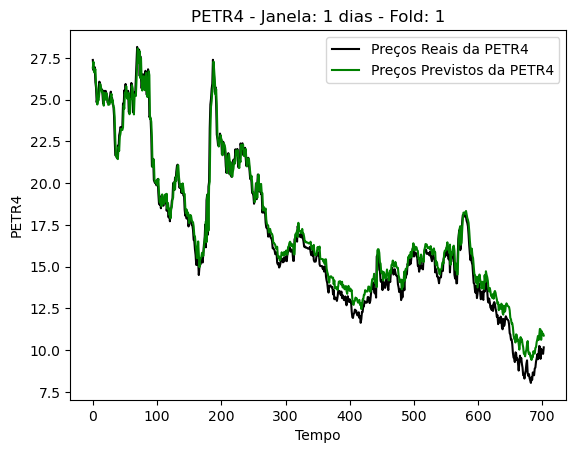

Reloading Tuner from tuner_results_1days_fold1\lstm_tuning_PETR4\tuner0.json


c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


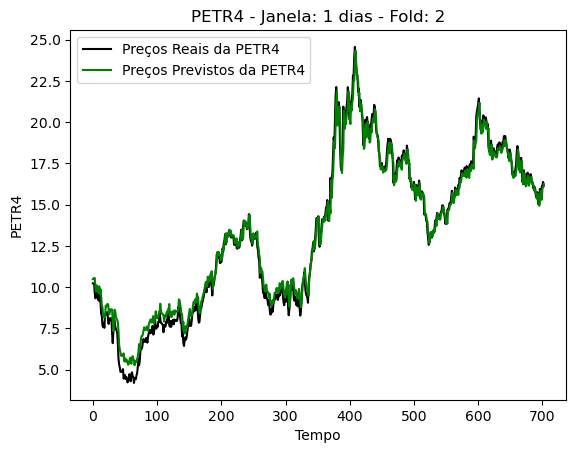

Reloading Tuner from tuner_results_1days_fold2\lstm_tuning_PETR4\tuner0.json
 1/22 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step

c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


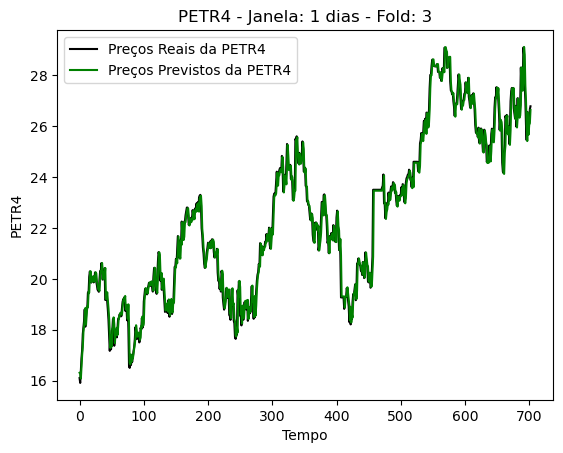

Reloading Tuner from tuner_results_1days_fold3\lstm_tuning_PETR4\tuner0.json
 1/22 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step

c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


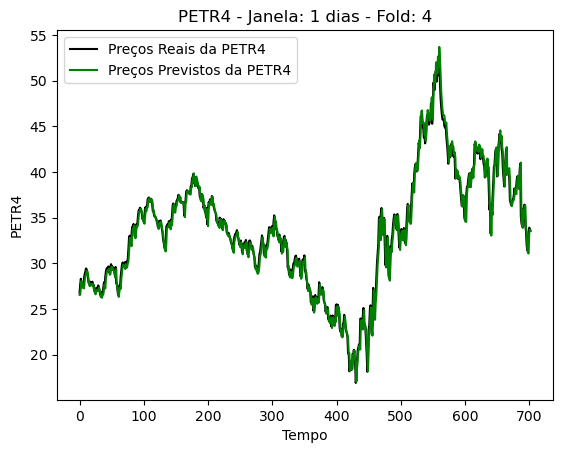

Reloading Tuner from tuner_results_1days_fold4\lstm_tuning_PETR4\tuner0.json


c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


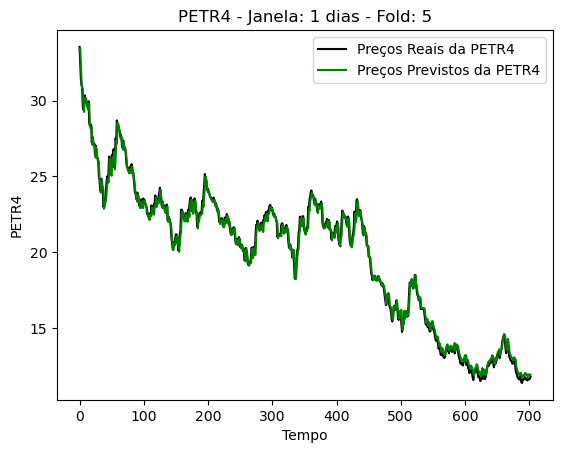

Reloading Tuner from tuner_results_2days_fold0\lstm_tuning_PETR4\tuner0.json
 1/22 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step

c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


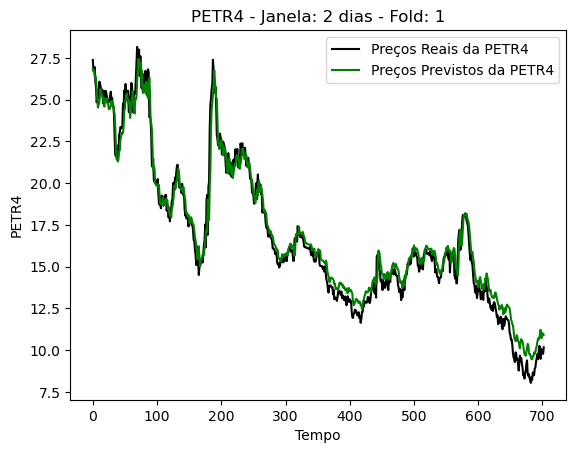

Reloading Tuner from tuner_results_2days_fold1\lstm_tuning_PETR4\tuner0.json
 1/22 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step

c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


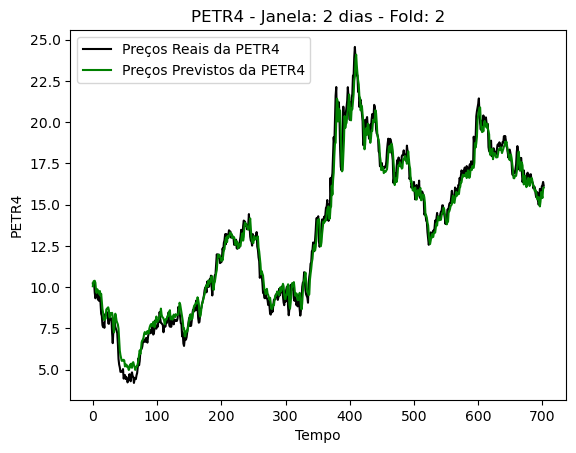

Reloading Tuner from tuner_results_2days_fold2\lstm_tuning_PETR4\tuner0.json


c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


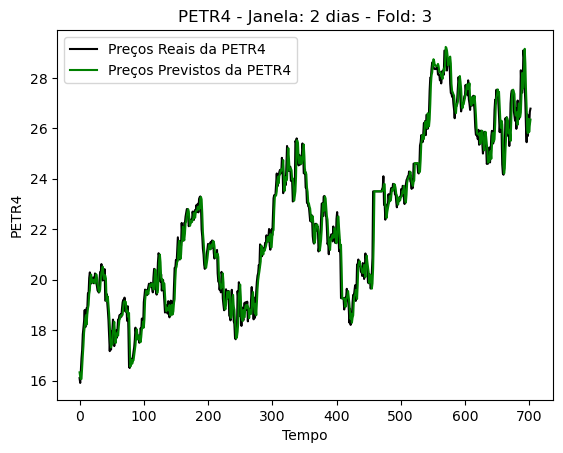

Reloading Tuner from tuner_results_2days_fold3\lstm_tuning_PETR4\tuner0.json


c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


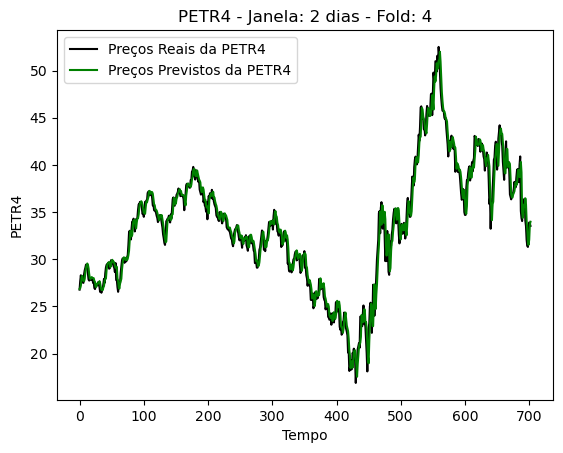

Reloading Tuner from tuner_results_2days_fold4\lstm_tuning_PETR4\tuner0.json


c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


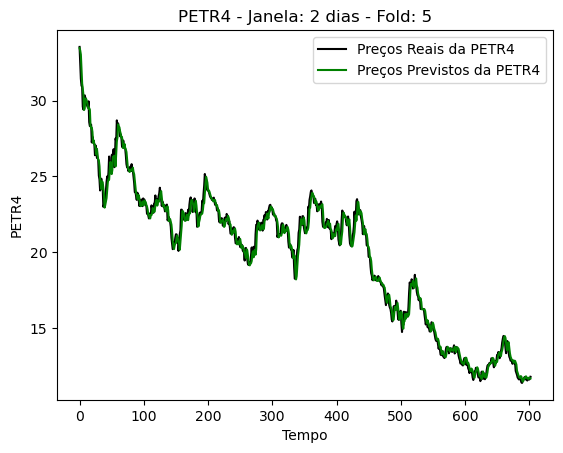

Reloading Tuner from tuner_results_3days_fold0\lstm_tuning_PETR4\tuner0.json
 1/22 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step

c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


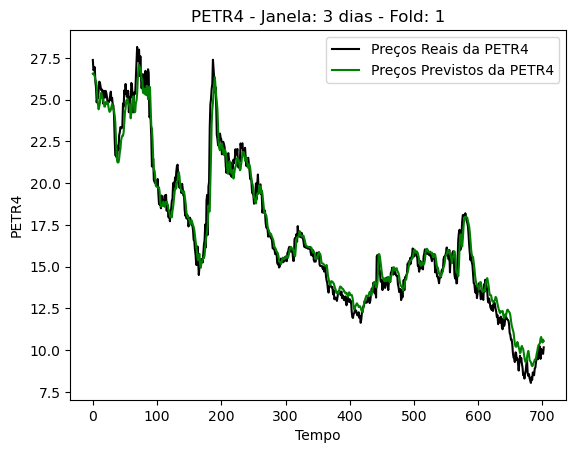

Reloading Tuner from tuner_results_3days_fold1\lstm_tuning_PETR4\tuner0.json


c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


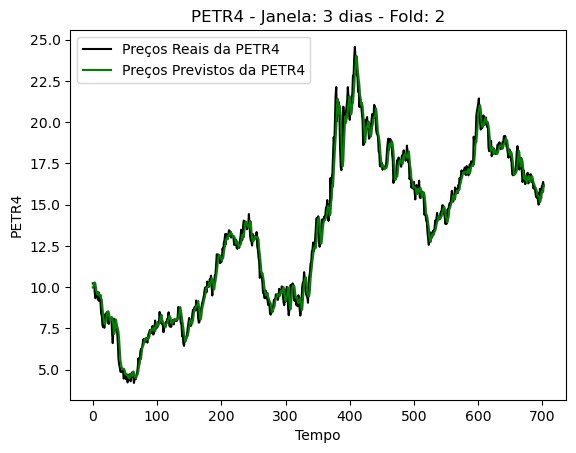

Reloading Tuner from tuner_results_3days_fold2\lstm_tuning_PETR4\tuner0.json
 1/22 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step

c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


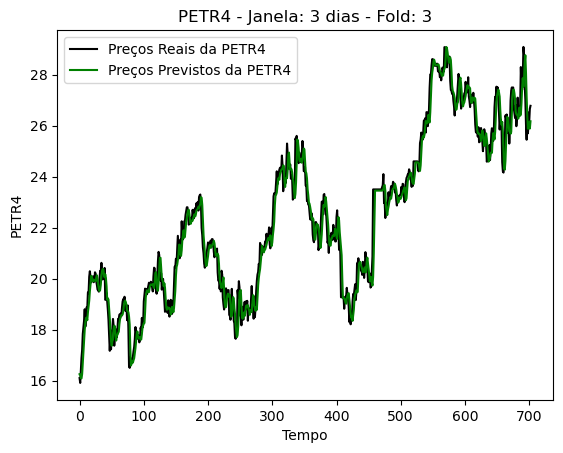

Reloading Tuner from tuner_results_3days_fold3\lstm_tuning_PETR4\tuner0.json
 1/22 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step

c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


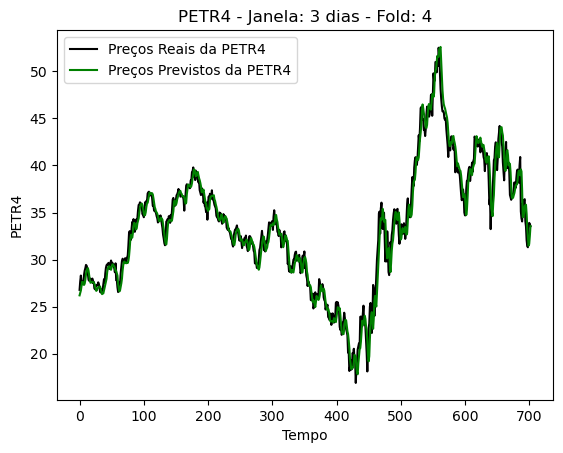

Reloading Tuner from tuner_results_3days_fold4\lstm_tuning_PETR4\tuner0.json
 1/22 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step

c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


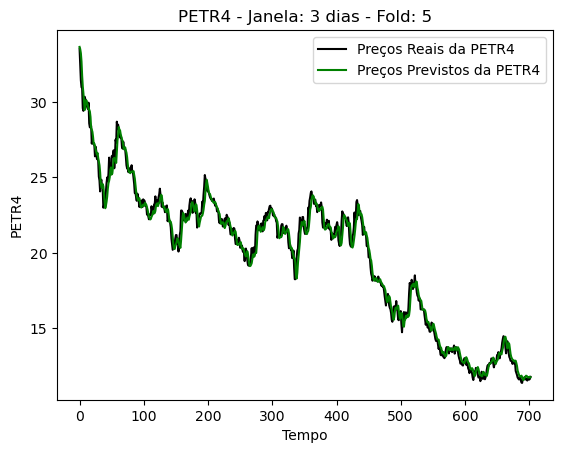

Reloading Tuner from tuner_results_4days_fold0\lstm_tuning_PETR4\tuner0.json


c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


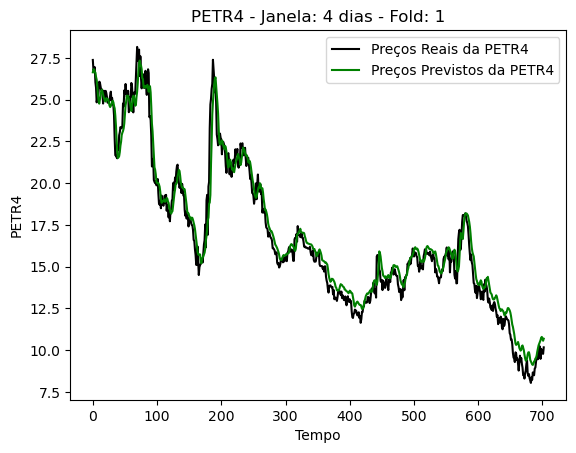

Reloading Tuner from tuner_results_4days_fold1\lstm_tuning_PETR4\tuner0.json


c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


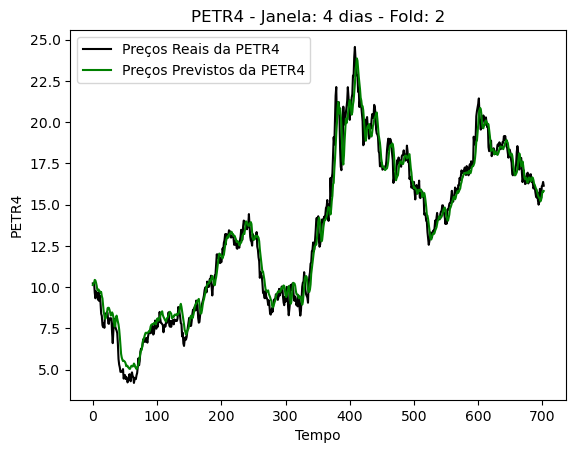

Reloading Tuner from tuner_results_4days_fold2\lstm_tuning_PETR4\tuner0.json
 1/22 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step

c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


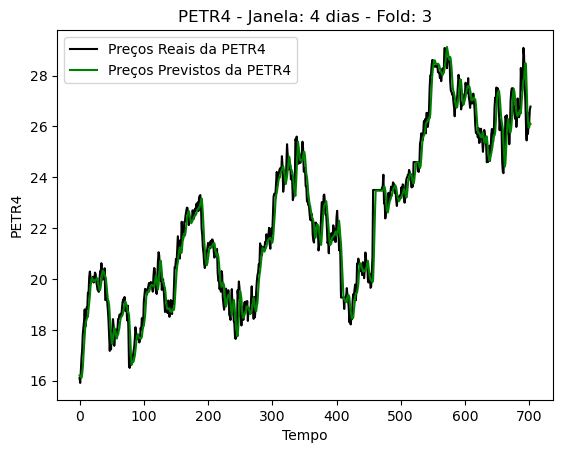

Reloading Tuner from tuner_results_4days_fold3\lstm_tuning_PETR4\tuner0.json
 1/22 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step

c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


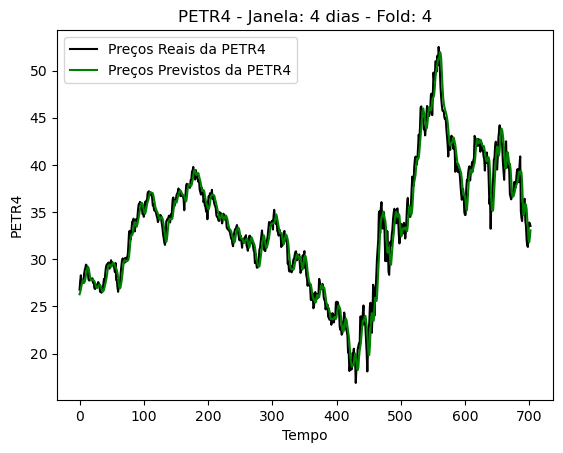

Reloading Tuner from tuner_results_4days_fold4\lstm_tuning_PETR4\tuner0.json
 1/22 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step

c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\leona\anaconda3\envs\ambiente\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


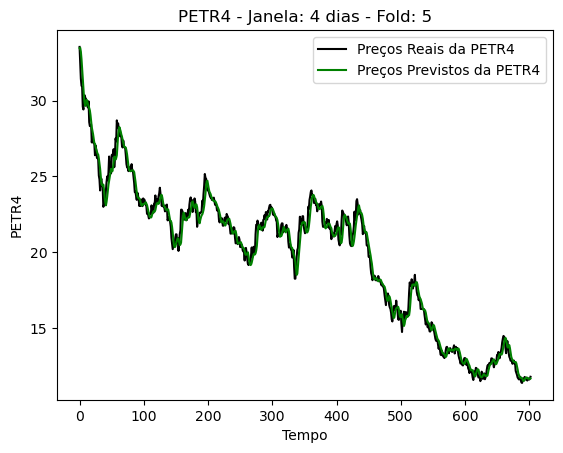

📊 Colunas disponíveis no DataFrame: Index(['Days', 'Fold', 'MAE', 'MSE', 'RMSE', 'R²', 'Learning Rate', 'Layers',
       'Units L0', 'Dropout L0', 'Units L1', 'Dropout L1'],
      dtype='object')
✅ Resultados salvos com sucesso!


In [24]:
api_key = "fd7758c9dfaa4fcab8e02ebb0212b7ea"
symbol = "PETR4"
start_date = "2005-01-01"
end_date = "2021-12-31"

dados = carregarDadosPreco(symbol, api_key, start_date, end_date)
dados, scaler = normalizarDados(dados)
if dados is not None:
    executarModelo(symbol, dados, scaler)
else:
    print("Erro: Não foi possível carregar os dados.")
